## Sign Language Image Classification

In [6]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from PIL import Image
from IPython.display import clear_output

import torch
from tqdm.auto import tqdm
import torch.nn as nn

nn.Conv2d

import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet201, DenseNet201_Weights

warnings.filterwarnings("ignore")
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
markup_df = pd.read_csv("/kaggle/input/sign-language-image-classification/train.csv")
markup_df.iloc[0:100]

,id,label
0,b1627fb5d6af156b41c46704bc041416.jpg,8
1,bf61d61ec5f282372b76311e2594b94f.jpg,13
2,1e963951fb29f4f37d9a153e14533d80.jpg,17
3,4aec4a36181bd02af6040e3b4eef8378.jpg,14
4,78740bc6ad7b6ca6fe572a580ffa65e0.jpg,16
...,...,...
95,aa3b6efc78d94d4de086664e813cc817.jpg,12
96,0e03575ec4c1f01b0032d6aeac5566a1.jpg,4
97,cda65a685554b06326a8f2968c569e00.jpg,2
98,ede446c3cf87bb000d8c9347080487fb.jpg,7


In [8]:
len(set(markup_df['label'].to_list())) # количество классов

20

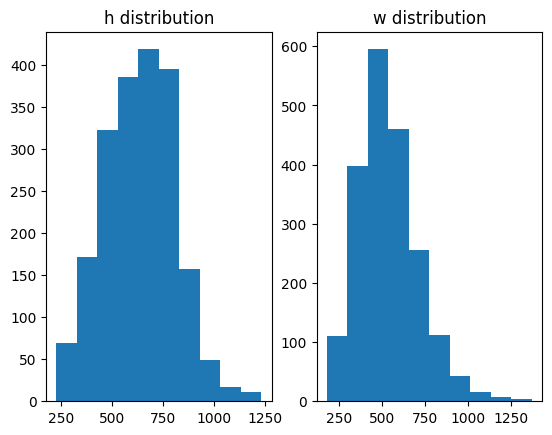

In [9]:
# Размеры изображений
h_list, w_list = [], []
img_name_list = markup_df['id'].to_list()
for name in img_name_list:
    img = np.array(Image.open("/kaggle/input/sign-language-image-classification/images/images/train/" + name))
    h, w, c = img.shape
    h_list.append(h)
    w_list.append(w)

plt.subplot(121)
plt.title("h distribution")
plt.hist(h_list)
plt.subplot(122)
plt.title("w distribution")
plt.xticks(np.arange(0, 1270, step=250))
plt.hist(w_list)
plt.show()

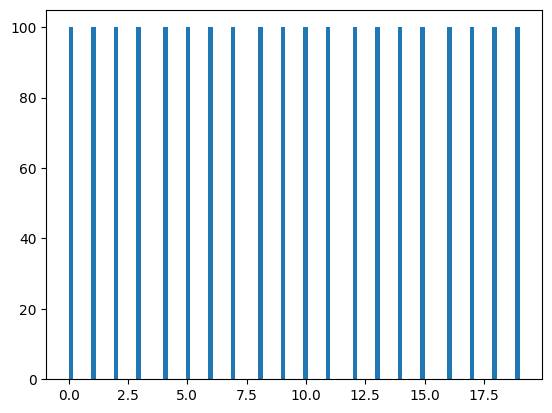

In [10]:
# Распределение по классам
plt.hist(markup_df['label'].to_list(), bins=100) 
plt.show()

In [11]:
base_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((180,180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [12]:
class HandGesturesDataset(Dataset):
    """Hands Gestures dataset."""

    def __init__(self, csv_file, root_dir, set, transform=None, TV_model=None):
        """
        Args:
            csv_file(string): Путь к csv файлу с аннотациями.
            root_dir (string): Каталог со всеми изображениями.
            set(string: train, val or test): является выборка 
                обучающейся, валидационной или тестовой.
            transform (callable, optional): Необязательный transform 
                который будет применен к экземпляру.
            TV_model(bool, optional): torchvision model с помощью которой 
                будет обучаться датасет.
        """
        self.root_dir = root_dir
        self.set = set
        self.transform = transform
        self.TV_model = TV_model
        self.gestures_frame = pd.read_csv(csv_file)
        if self.set=='train':
            self.images_name = self.gestures_frame.iloc[0:1799,0]
            self.labels = self.gestures_frame.iloc[0:1799,1]
        elif self.set=='val':
            self.gestures_test = self.gestures_frame.iloc[1800:1999].reset_index()
            del self.gestures_test["index"]
            self.images_name = self.gestures_test.iloc[0:,0]
            self.labels = self.gestures_test.iloc[0:,1]
        elif self.set=='test':
            self.images_name = self.gestures_frame.iloc[0:,0]

    def __getitem__(self, idx):
        image = self.images_name[idx]  
        image = Image.open(os.path.join(self.root_dir, image))
        if self.TV_model:
            preprocess = weights.transforms()
            image = preprocess(image)
        
        image = np.array(image)
        if self.transform:
            
            image = self.transform(image)
            
        if self.set=='train' or self.set=='val':
            label = self.labels[idx]
            return image, label
        elif self.set=='test':
            return image
    
    def __len__(self):
        return len(self.images_name)

In [13]:
hand_train = HandGesturesDataset(csv_file='/kaggle/input/sign-language-image-classification/train.csv',
                                 root_dir='/kaggle/input/sign-language-image-classification/images/images/train/', 
                                 set='train', transform=base_transforms)

train_dataloader = DataLoader(hand_train, batch_size=32, shuffle=True, drop_last=True)

hand_val = HandGesturesDataset(csv_file='/kaggle/input/sign-language-image-classification/train.csv',
                               root_dir='/kaggle/input/sign-language-image-classification/images/images/train/', 
                               set='val', transform=base_transforms)

val_dataloader = DataLoader(hand_train, batch_size=32, shuffle=True, drop_last=True)

In [14]:
# функция для показа изображений
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

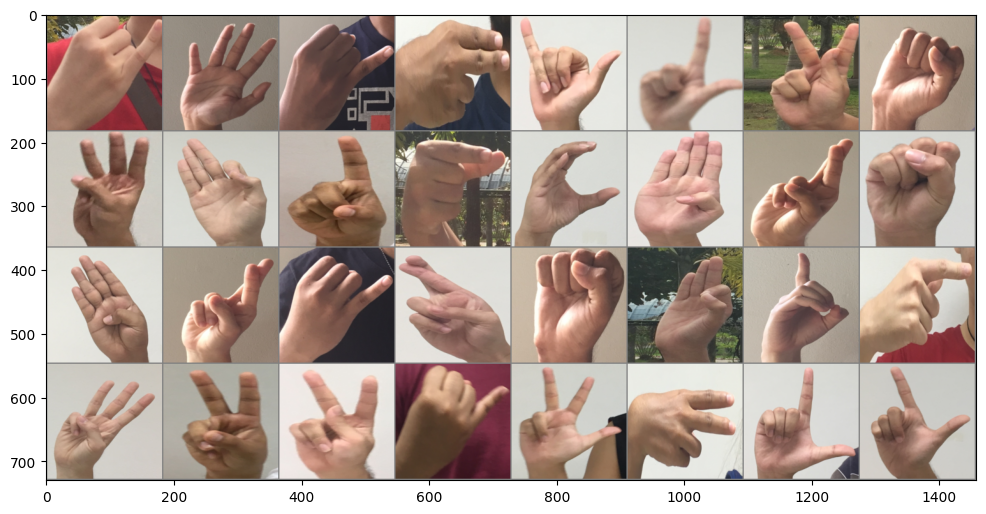

In [15]:
# получаем несколько случайных тренировочных изображений
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(12, 12))
# показываем изображения
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)

In [16]:
# функция для показа статистики
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [17]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    # проходим в цикле по набору данных несколько раз
    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            # получаем вводные данные
            imgs, labels = imgs.to(device), labels.to(device)

            # forward + backward + optimize
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            # обнуляем параметр градиента
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        if scheduler:
           scheduler.step()

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        
        # статистика
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                train_epoch_true_hits.sum()
                / train_epoch_true_hits.size(0)
                / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                val_epoch_true_hits.sum()
                / val_epoch_true_hits.size(0)
                / val_dataloader.batch_size
            ).item(),
        )

In [18]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(64 * 22 * 22, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 20),
)

In [19]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

lambda_func = lambda epoch: 0.975**epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

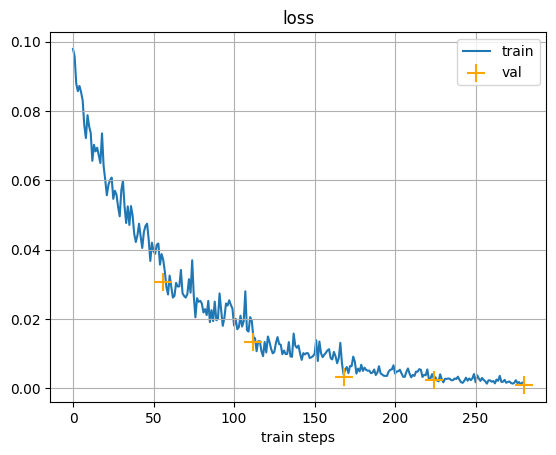

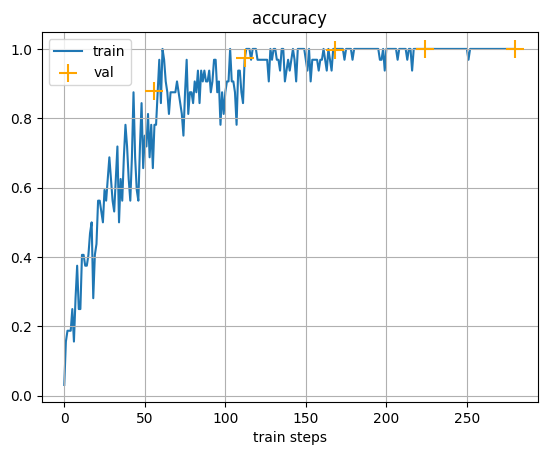

Train loss: 0.002342622959986329
Train acc: 0.9994419813156128
Val loss: 0.0009868188062682748
Val acc: 1.0


In [20]:
train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=5)

## torchvision model - densenet201

In [25]:
weights = DenseNet201_Weights.IMAGENET1K_V1
model = densenet201(pretrained=True)

In [26]:
hand_train = HandGesturesDataset(csv_file='/kaggle/input/sign-language-image-classification/train.csv',
                                 root_dir='/kaggle/input/sign-language-image-classification/images/images/train/',
                                 set='train', TV_model=True)

train_dataloader = DataLoader(hand_train, batch_size=32, shuffle=True, drop_last=True)

hand_val = HandGesturesDataset(csv_file='/kaggle/input/sign-language-image-classification/train.csv',
                               root_dir='/kaggle/input/sign-language-image-classification/images/images/train/',
                               set='val', TV_model=True)

val_dataloader = DataLoader(hand_val, batch_size=32, shuffle=True, drop_last=True)

In [27]:
model.to(device)
criterion = nn.CrossEntropyLoss()
lambda_func = lambda epoch: 0.975**epoch
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

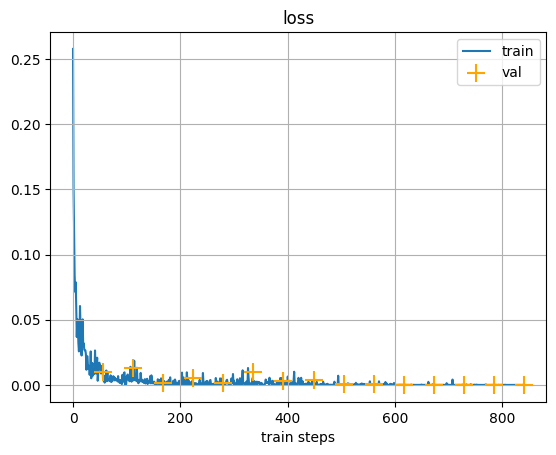

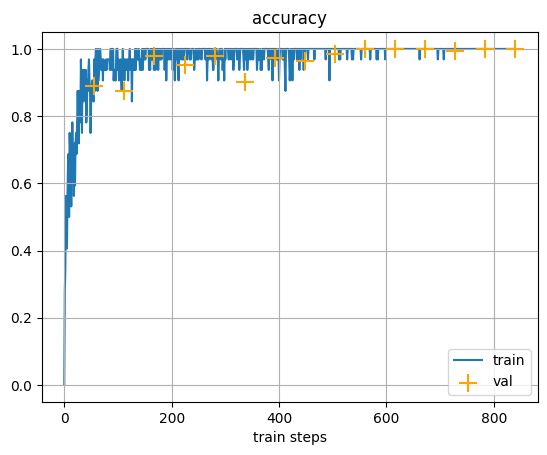

Train loss: 2.8960936106159352e-05
Train acc: 1.0
Val loss: 6.0878137446707115e-05
Val acc: 1.0


In [28]:
train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=15)

## Проверка сетки

In [29]:
test = HandGesturesDataset(csv_file='/kaggle/input/sign-language-image-classification/submit.csv',
                           root_dir='/kaggle/input/sign-language-image-classification/images/images/test/', 
                           set='test', TV_model=True)

test_dataloader = DataLoader(test, batch_size=32, shuffle=False)

In [30]:
def predict(model, test_dataloader):

    model.eval()
    with torch.no_grad():
        pred_classes_log = torch.empty(0)
        for imgs in tqdm(test_dataloader, leave=False):
            imgs = imgs.to(device)
            y_pred = model(imgs)

            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)

            pred_classes_log = torch.cat((pred_classes_log, (pred_classes).unsqueeze(0)))

    return pred_classes_log
                

In [31]:
result = predict(model, test_dataloader)

submit = pd.read_csv('/kaggle/input/sign-language-image-classification/submit.csv')
submit['predict'] = torch.ravel(result).type(torch.int64)
submit[['id','predict']].to_csv('/kaggle/working/submission.csv', index=False)
submit

  0%|          | 0/47 [00:00<?, ?it/s]

,id,predict
0,5f3540c43f86dab2c9a7c87834311ee3.jpg,4
1,7f14db51f1994bce42972c7fe111f5cd.jpg,18
2,092908960a3d4dccbe06a60b71dcdd98.jpg,19
3,542ed4f107f9472457b47a436ec55e60.jpg,5
4,c125af0d467cffe584728aad4b426d53.jpg,1
...,...,...
1499,480bd34d7aaddb2f15d897f6fa938a1a.jpg,17
1500,610ecbaf1f77fcbd8dda0f664c084769.jpg,3
1501,f9e8adc8f33ef85d7ece4220537e9fec.jpg,9
1502,826744d31261d3fd854b7bf93f2952c5.jpg,11
